#### Load necessary libraries

In [101]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import train_test_split as tts
import pandas as pd 
from numpy import loadtxt
from sklearn.feature_extraction.text import TfidfVectorizer

from preprocess import preprocess_text
# from AL import batch_creator
# from AL import make_prediction
# from AL import active_learning_model
# from AL import active_learning

import warnings
warnings.filterwarnings("ignore")

##### Load Dataset

In [64]:
labelled_data = pd.read_csv("D://FALL 2022//CSC2515 INTRO TO ML//Active_Learning_Based_Research_Paper_Classification//data//labelled//cs_data.csv")

# Preprocessing CS data
df = labelled_data[['title', 'abstract','categories']]
df['title'] = preprocess_text(df, 'title')
df['abstract'] = preprocess_text(df, 'abstract')
df["text"] = df["title"] + df["abstract"]

labelled, unlabelled=tts(df,test_size=0.8, random_state=7)

# Unlabelled Dataset from arxiv API
api_unlab = pd.read_csv("D://FALL 2022//CSC2515 INTRO TO ML//Active_Learning_Based_Research_Paper_Classification//data//unlabelled_data//api_unlabelled.csv")
api_unlab.drop(['Unnamed: 0'], axis=1, inplace=True)
api_unlab['Title'] = preprocess_text(api_unlab, 'Title')
api_unlab['Abstract'] = preprocess_text(api_unlab, 'Abstract')
api_x = api_unlab[['Title', 'Abstract']].agg(' '.join, axis=1)
api_df = pd.Series(api_x,
              name="text")
api_df = api_df.to_frame(name="text")

In [68]:
unlabelled = unlabelled[["text"]]

In [69]:
# Creating final Preprocessed Unlabelled Dataset: API + Kaggle
unlabelled_data = unlabelled.append(api_df, ignore_index=True)

#### Preprocess data

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import train_test_split as tts

x = labelled["text"]
y = labelled["categories"]

tfidf_vect = TfidfVectorizer(max_features=1000,
                       stop_words ='english')
X = tfidf_vect.fit_transform(x)
X = pd.DataFrame(X.A, columns=tfidf_vect.get_feature_names_out())
sm2 = BorderlineSMOTE(random_state=42)
X_tfidf, y_tfidf = sm2.fit_resample(X, y)

X_tfidf["categories"] = y_tfidf
X_tfidf = X_tfidf.sample(frac=1, random_state=7)

x = X_tfidf.drop(['categories'], axis=1)
y = X_tfidf["categories"]

Create Training and Testing set

In [73]:
train_x,test_x,train_y,test_y=tts(x,y,test_size=0.4,stratify=y, random_state=7)

#### Training Supervised Model

In [121]:
lg = RandomForestClassifier(n_estimators=250)
lg.fit(train_x, train_y)
pred = lg.predict(test_x)
train_preds = lg.predict(train_x)

print("Training Accuracy : ", accuracy_score(train_y, train_preds))
print("Testing Accuracy : ", accuracy_score(test_y,pred))

Training Accuracy :  1.0
Testing Accuracy :  0.9110204081632653


### Active Learning

In [115]:
from scipy.stats import entropy
X_unlab = tfidf_vect.transform(unlabelled_data["text"])
unlab_prob = lg.predict_proba(X_unlab)
unlab_entropy = np.apply_along_axis(entropy, 1, unlab_prob)

In [116]:
from scipy.stats import entropy
def make_prediction(data):
    batch_vect = tfidf_vect.transform(data.to_numpy()).toarray()
    batch_prediction = lg.predict(batch_vect)
    prob_prediction = lg.predict_proba(batch_vect)
    return batch_prediction, prob_prediction

In [117]:
def batch_creator(df, batch_size):
    return (df[pos: pos + batch_size] for pos in range(0, len(df), batch_size))

In [120]:
def active_learning_model(traindata, trainlabels):
    x = traindata
    y = trainlabels
    
    lg = RandomForestClassifier(n_estimators=250)
    active_lg = lg.fit(x, y)

    active_train_preds = active_lg.predict(x)
    active_preds = active_lg.predict(test_x)
    
    train_active_acc = accuracy_score(y, active_train_preds)
    active_acc = accuracy_score(test_y, active_preds)
    print()
    print(classification_report(test_y, active_preds))
    return active_lg, active_acc, train_active_acc

In [122]:
import warnings
warnings.filterwarnings("ignore")
batch_num = 0
batch_size=500
cutoff=0.75
cutoff_prob = 0.30
train_data = train_x 
train_labels = train_y

TrainAcc = []
TestAcc = []
samples_added = []

for batch in batch_creator(unlabelled_data, batch_size):
    sampled_pool = pd.DataFrame()
    predictions, probabilities = make_prediction(batch["text"])
    try: 
        for index, data in batch.iterrows():
            i = index - batch_num * batch_size
            if(np.max(probabilities[i]) <= cutoff_prob or unlab_entropy[index] >= cutoff):
                sampled_pool = sampled_pool.append({
                    'text': data["text"],
                    'categories': predictions[index - batch_num * batch_size]
                }, ignore_index=True)   
        print(sampled_pool)
        new_data = tfidf_vect.transform(sampled_pool["text"])
        new_data = pd.DataFrame(new_data.A, columns=tfidf_vect.get_feature_names_out())
        train_data = np.vstack((train_data, new_data))

        new_labels = sampled_pool["categories"]
        train_labels = train_labels.append(new_labels)

        active_model, active_score, train_active_score = active_learning_model(train_data, train_labels)
        TrainAcc.append(train_active_score)
        TestAcc.append(active_score)
        samples_added.append(train_data.shape[0] - new_data.shape[0])
        print("Testing score : ", active_score)
        print("Training score : ", train_active_score)
        print(train_data.shape)
        print("***********************")
        print()
    except Exception as e:
        continue
        
    batch_num += 1
    

    categories                                               text
0        cs.AI  hierarchical reinforcement learning a a model ...
1        cs.NI  haystack a multi purpose mobile vantage point ...
2        cs.DS  document clustering using k mean and k medoids...
3        cs.IR  towards a simplified ontology for better e com...
4        cs.HC  effect of hand representation for typing in vi...
..         ...                                                ...
495      cs.NI  nancy an efficient parallel network calculus l...
496      cs.IR  ranking v classifying measuring knowledge base...
497      cs.CR  the security utility trade off for iris authen...
498      cs.NI  qos aware dynamic fog service provisioningrece...
499      cs.CR  generative adversarial network in the air deep...

[500 rows x 2 columns]

              precision    recall  f1-score   support

       cs.AI       0.85      0.83      0.84       700
       cs.AR       0.99      0.98      0.99       700
       cs.CR       0


              precision    recall  f1-score   support

       cs.AI       0.86      0.82      0.84       700
       cs.AR       0.99      0.99      0.99       700
       cs.CR       0.89      0.87      0.88       700
       cs.DS       0.89      0.93      0.91       700
       cs.HC       0.90      0.95      0.93       700
       cs.IR       0.95      0.95      0.95       700
       cs.NI       0.89      0.87      0.88       700

    accuracy                           0.91      4900
   macro avg       0.91      0.91      0.91      4900
weighted avg       0.91      0.91      0.91      4900

Testing score :  0.9112244897959184
Training score :  1.0
(10350, 1000)
***********************

    categories                                               text
0        cs.HC  how should voice assistant deal with user emot...
1        cs.NI  the bittorrent anonymity marketplacethe very n...
2        cs.AI  optiplan unifying ip based and graph based pla...
3        cs.CR  dns attack mitigation usi

    categories                                               text
0        cs.AR  hashcore proof of work function for general pu...
1        cs.CR  computation on encrypted data using data flow ...
2        cs.DS  how to discover a semantic web service by know...
3        cs.HC  adaptive data communication interface a user c...
4        cs.NI  performance of offloading strategy in collocat...
..         ...                                                ...
495      cs.CR  sirenattack generating adversarial audio for e...
496      cs.CR  real time recognition of smartphone user behav...
497      cs.CR  holmes real time apt detection through correla...
498      cs.NI  head mouse a simple cursor controller based on...
499      cs.AI  fdconfig a constraint based interactive produc...

[500 rows x 2 columns]

              precision    recall  f1-score   support

       cs.AI       0.83      0.83      0.83       700
       cs.AR       0.99      0.98      0.99       700
       cs.CR       0


              precision    recall  f1-score   support

       cs.AI       0.83      0.82      0.83       700
       cs.AR       0.99      0.98      0.99       700
       cs.CR       0.88      0.87      0.87       700
       cs.DS       0.89      0.92      0.91       700
       cs.HC       0.91      0.95      0.93       700
       cs.IR       0.96      0.95      0.95       700
       cs.NI       0.89      0.86      0.88       700

    accuracy                           0.91      4900
   macro avg       0.91      0.91      0.91      4900
weighted avg       0.91      0.91      0.91      4900

Testing score :  0.9069387755102041
Training score :  1.0
(15850, 1000)
***********************

    categories                                               text
0        cs.CR  a generic privacy preserving protocol for keys...
1        cs.CR  never trust your victim weaponizing vulnerabil...
2        cs.CR  privacy leakage in mobile computing tool metho...
3        cs.NI  bootstrapping key pre dis

    categories                                               text
0        cs.DS  vertex sparsification for edge connectivitygra...
1        cs.HC  lina a social augmented reality game around me...
2        cs.DS  improved bound for shortest path in dense dist...
3        cs.NI  oblivious routing via random walkwe present no...
4        cs.NI  haptic teleoperation go wireless evaluation an...
..         ...                                                ...
495      cs.AI  a bayesian approach to identifying representat...
496      cs.NI  radio link planning made easy with a telegram ...
497      cs.AR  secret sharing mpc on fpgas in the datacenterm...
498      cs.DS  fully functional bidirectional burrow wheeler ...
499      cs.IR  timemachine entity centric search and visualiz...

[500 rows x 2 columns]

              precision    recall  f1-score   support

       cs.AI       0.82      0.83      0.83       700
       cs.AR       0.99      0.98      0.99       700
       cs.CR       0


              precision    recall  f1-score   support

       cs.AI       0.84      0.82      0.83       700
       cs.AR       0.99      0.98      0.99       700
       cs.CR       0.88      0.87      0.88       700
       cs.DS       0.90      0.92      0.91       700
       cs.HC       0.89      0.94      0.92       700
       cs.IR       0.95      0.94      0.95       700
       cs.NI       0.89      0.87      0.88       700

    accuracy                           0.91      4900
   macro avg       0.91      0.91      0.91      4900
weighted avg       0.91      0.91      0.91      4900

Testing score :  0.9073469387755102
Training score :  1.0
(21350, 1000)
***********************

    categories                                               text
0        cs.AI  reliable uncertain evidence modeling in bayesi...
1        cs.AR  deepdive an integrative algorithm architecture...
2        cs.NI  smart contract based secure spectrum sharing i...
3        cs.CR  the kiss principle in sof

    categories                                               text
0        cs.HC  analysis and correlation of visual evidence in...
1        cs.NI  multipath routing with novel packet scheduling...
2        cs.AI  top frequency parallel coordinate plotparallel...
3        cs.NI  the case for hop by hop traffic engineeringsta...
4        cs.IR  dealing with typo for bert based passage retri...
..         ...                                                ...
495      cs.AR  extending high level synthesis for task parall...
496      cs.DS  sequential and parallel algorithm for the addi...
497      cs.NI  bgp multipath routing in the internetbgp multi...
498      cs.HC  geosneakpique visual autocompletion for geospa...
499      cs.IR  uprec user aware pre training for recommender ...

[500 rows x 2 columns]

              precision    recall  f1-score   support

       cs.AI       0.82      0.83      0.82       700
       cs.AR       0.99      0.98      0.98       700
       cs.CR       0


              precision    recall  f1-score   support

       cs.AI       0.83      0.82      0.83       700
       cs.AR       0.99      0.98      0.99       700
       cs.CR       0.88      0.87      0.87       700
       cs.DS       0.90      0.92      0.91       700
       cs.HC       0.90      0.94      0.92       700
       cs.IR       0.95      0.94      0.95       700
       cs.NI       0.90      0.86      0.88       700

    accuracy                           0.91      4900
   macro avg       0.91      0.91      0.91      4900
weighted avg       0.91      0.91      0.91      4900

Testing score :  0.9057142857142857
Training score :  1.0
(26850, 1000)
***********************

    categories                                               text
0        cs.NI  a neuro fuzzy approach for modelling electrici...
1        cs.IR  ultragcn ultra simplification of graph convolu...
2        cs.NI  on connectivity of airborne networkmobility pa...
3        cs.IR  a new simple and effectiv

    categories                                               text
0        cs.AI  a framework for fairness a systematic review o...
1        cs.DS  ramsey spanning tree and their applicationthe ...
2        cs.AI  ss alpha beta ttin stockman introduced the ss ...
3        cs.DS  fast locality sensitive hashing framework for ...
4        cs.IR  elecrec training sequential recommenders a dis...
..         ...                                                ...
495      cs.CR  where s crypto automated identification and cl...
496      cs.NI  technical report contikimac v x mac performanc...
497      cs.AI  bridging between legalruleml and tptp for auto...
498      cs.NI  csma ca bottleneck remediation in saturation m...
499      cs.AI  ai bn an adaptive importance sampling algorith...

[500 rows x 2 columns]

              precision    recall  f1-score   support

       cs.AI       0.82      0.83      0.83       700
       cs.AR       0.99      0.97      0.98       700
       cs.CR       0


              precision    recall  f1-score   support

       cs.AI       0.82      0.82      0.82       700
       cs.AR       0.99      0.97      0.98       700
       cs.CR       0.88      0.87      0.88       700
       cs.DS       0.90      0.92      0.91       700
       cs.HC       0.89      0.93      0.91       700
       cs.IR       0.95      0.94      0.94       700
       cs.NI       0.89      0.86      0.88       700

    accuracy                           0.90      4900
   macro avg       0.90      0.90      0.90      4900
weighted avg       0.90      0.90      0.90      4900

Testing score :  0.9022448979591837
Training score :  1.0
(32350, 1000)
***********************

    categories                                               text
0        cs.DS  good transportation problem solving via routin...
1        cs.AI  probabilistic logic programming under inherita...
2        cs.AI  descriptive complexity based distance for fuzz...
3        cs.NI  statistical analysis to e

KeyboardInterrupt: 

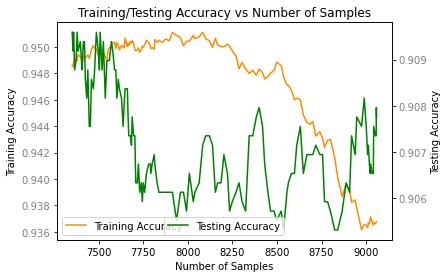

In [46]:
import matplotlib.pyplot as plt
y1 = TrainAcc
y2 = TestAcc
x = samples_added
fig, ax = plt.subplots()

ax.plot(x, y1, color='darkorange', label="Training Accuracy")
ax.tick_params(axis='y', labelcolor='gray')
ax.legend(loc="lower left")
ax2 = ax.twinx()
ax2.plot(x, y2, color='green', label="Testing Accuracy")
ax2.tick_params(axis='y', labelcolor='gray')
ax2.legend(loc='lower center')
ax.set_xlabel("Number of Samples")
ax.set_ylabel("Training Accuracy")
ax2.set_ylabel("Testing Accuracy")
plt.title("Training/Testing Accuracy vs Number of Samples")
plt.savefig("al_plot_test.png", dpi=800)
plt.show()